In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import scipy.stats as st
from scipy import stats

np.random.seed(41)

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
#sc.logging.print_versions()

In [2]:
# Read pre-processed data
save_file = 'data/results/scanpy_preprocess_classification.h5ad'
adata = sc.read_h5ad(save_file)
adata

AnnData object with n_obs × n_vars = 5594 × 3066
    obs: 'type', 'sample', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt2', 'n_counts', 'n_genes', 'S_score', 'G2M_score', 'phase', 'doublet_scores', 'predicted_doublets', 'doublet_info'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'doublet_info_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'sample_colors', 'tsne', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

### Add a new columns: covid_non_covid to adata.obs

This allows us to visualize clusters in UMAP with only a covid patients and non-covid patients.

In [4]:
list_covid = ['covid_1', 'covid_15', 'covid_17']
list_non_covid = ['ctrl_5', 'ctrl_13', 'ctrl_14']

for index, row in adata.obs.iterrows():
     if row['sample'] in list_covid:
          new_value = 'covid'
     elif row['sample'] in list_non_covid:
          new_value = 'non_covid'

     adata.obs.at[index, 'covid_non_covid'] = new_value

In [7]:
print('Number of cells of all samples in covid and non covid.')
print(adata.obs['covid_non_covid'].value_counts())

Number of cells of all samples in covid and non covid.
non_covid    3131
covid        2463
Name: covid_non_covid, dtype: int64


In [12]:
print('Number of cells of each sample in covid and non covid.')
adata.obs.groupby('sample')['covid_non_covid'].count()

Number of cells of each sample in covid and non covid.


sample
covid_1      854
covid_15     581
covid_17    1028
ctrl_5      1019
ctrl_13     1124
ctrl_14      988
Name: covid_non_covid, dtype: int64

## Sample Classification: Scenario 1

### Input data
UMAP representation (UMAP 1 - UMAP 2)

### Method
Get KDEs of covid and non-covid from UMAP representation (UMAP1~2), and compare them with a new sample cluster’s KDE by KL-divergence.


* Sample for making KDE of covid and non-covid: covid_1, covid_15, ctrl_5, ctl_13
* Sample to measure how similar to two KDEs: covid_17, ctlr_14


### Hypothesis
There should be similarity between covid samples in KDE, and difference compared to non-covid samples. 

### Get PDE and KDE from UMAP representation in sample making KDE of covid and non-covid

In [191]:
basis_values = adata.obsm['X_umap']

sample_vector = adata.obs['sample'].values

df_pds = pd.DataFrame(list(zip(basis_values, sample_vector)),
               columns =['basis_value', 'sample'])
df_pds.head()


,basis_value,sample
0,"[10.045827, 3.8673859]",covid_1
1,"[2.4835434, 1.4139254]",covid_1
2,"[2.1057522, 1.870278]",covid_1
3,"[1.6517708, 6.245513]",covid_1
4,"[6.048353, 9.24604]",covid_1


In [187]:
covid_vector = df_pds.query("sample == 'covid_1' | sample == 'covid_15'")['basis_value'].values
non_covid_vector = df_pds.query("sample == 'ctrl_5' | sample == 'ctrl_13'")['basis_value'].values

new_covid_vector = []

for v in covid_vector:
    new_covid_vector.append(list(v))

new_non_covid_vector = []

for v in non_covid_vector:
    new_non_covid_vector.append(list(v))

covid_vector = np.array(new_covid_vector)
non_covid_vector = np.array(new_non_covid_vector)

print(f"Number of cells from selected covid samples: {len(covid_vector)}")
print(f"Number of cells from selected non-covid samples: {len(non_covid_vector)}")

Number of cells from selected covid samples: 1435
Number of cells from selected non-covid samples: 2143


In [192]:
x_covid = covid_vector[:, 0]
y_covid = covid_vector[:, 1]
x_n_covid = non_covid_vector[:, 0]
y_n_covid = non_covid_vector[:, 1]

# now determine nice limits by hand:
#binwidth = 0.25
binwidth = 1
xymax = np.max([np.max(np.fabs(x_covid)), np.max(np.fabs(y_covid))])
lim = (int(xymax/binwidth) + 1) * binwidth

kernel_x_covid = stats.gaussian_kde(x_covid)
kernel_y_covid = stats.gaussian_kde(y_covid)
kernel_x_n_covid = stats.gaussian_kde(x_n_covid)
kernel_y_n_covid = stats.gaussian_kde(y_n_covid)
n_sample_covid = np.linspace(-lim+5, lim+5, len(covid_vector)) #(start, stop, num=50 -> Number of samples to generate. Default is 50. Must be non-negative)
n_sample_non_covid = np.linspace(-lim+5, lim+5, len(non_covid_vector)) #(start, stop, num=50 -> Number of samples to generate. Default is 50. Must be non-negative)

# KDE for UMAP1 (x-axis)
kde_x_covid = kernel_x_covid(n_sample_covid)
kde_x_n_covid = kernel_x_n_covid(n_sample_covid)

# KDE for UMAP2 (y-axis)
kde_y_covid = kernel_y_covid(n_sample_covid)
kde_y_n_covid = kernel_y_n_covid(n_sample_covid)

Text(0.5, 1.0, 'KDE in UMAP2')

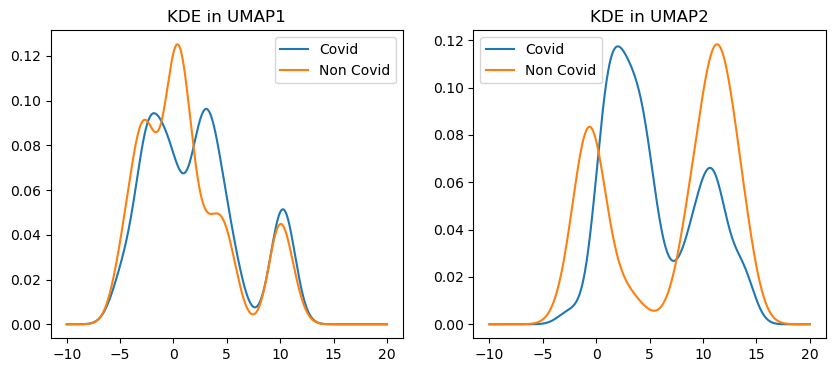

In [194]:
# Initialise the subplot function using number of rows and columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# For Covid KDE
ax1.plot(n_sample_covid, kde_x_covid, label='Covid')
ax1.plot(n_sample_covid, kde_x_n_covid, label='Non Covid')
ax1.legend()
ax1.set_title("KDE in UMAP1")

ax2.plot(n_sample_covid, kde_y_covid, label='Covid')
ax2.plot(n_sample_covid, kde_y_n_covid, label='Non Covid')
ax2.legend()
ax2.set_title("KDE in UMAP2")


### Plotting samples to measure how similar to two KDEs (UMAP1 and UMAP2): covid_17, ctlr_14

First, getting the vector of two samples: covid_17 and ctrl_14 from the UMAP representation.

In [195]:
covid_17_vector = df_pds.query("sample == 'covid_17'")['basis_value'].values
non_covid_14_vector = df_pds.query("sample == 'ctrl_14'")['basis_value'].values

new_covid_vector = []

for v in covid_17_vector:
    new_covid_vector.append(list(v))

new_non_covid_vector = []

for v in non_covid_14_vector:
    new_non_covid_vector.append(list(v))

covid_17_vector = np.array(new_covid_vector)
non_covid_14_vector = np.array(new_non_covid_vector)

print(f"Number of cells from selected covid samples: {len(covid_17_vector)}")
print(f"Number of cells from selected non-covid samples: {len(non_covid_14_vector)}")

Number of cells from selected covid samples: 1028
Number of cells from selected non-covid samples: 988


In [196]:
x_covid_17 = covid_17_vector[:, 0]
y_covid_17 = covid_17_vector[:, 1]
x_n_covid_14 = non_covid_14_vector[:, 0]
y_n_covid_14 = non_covid_14_vector[:, 1]

# now determine nice limits by hand:
#binwidth = 0.25
binwidth = 1
xymax = np.max([np.max(np.fabs(x_covid_17)), np.max(np.fabs(y_covid_17))])
lim = (int(xymax/binwidth) + 1) * binwidth

kernel_x_covid_17 = stats.gaussian_kde(x_covid_17)
kernel_y_covid_17 = stats.gaussian_kde(y_covid_17)
kernel_x_n_covid_14 = stats.gaussian_kde(x_n_covid_14)
kernel_y_n_covid_14 = stats.gaussian_kde(y_n_covid_14)
n_sample_covid_17 = np.linspace(-lim+5, lim+5, len(covid_vector)) #(start, stop, num=50 -> Number of samples to generate. Default is 50. Must be non-negative)
n_sample_non_covid_14 = np.linspace(-lim+5, lim+5, len(non_covid_vector)) #(start, stop, num=50 -> Number of samples to generate. Default is 50. Must be non-negative)

# KDE for UMAP1 (x-axis)
kde_x_covid_test = kernel_x_covid_17(n_sample_covid)
kde_x_n_covid_test = kernel_x_n_covid_14(n_sample_covid)

# KDE for UMAP2 (y-axis)
kde_y_covid_test = kernel_y_covid_17(n_sample_covid)
kde_y_n_covid_test = kernel_y_n_covid_14(n_sample_covid)

Text(0.5, 1.0, 'KDE in UMAP2')

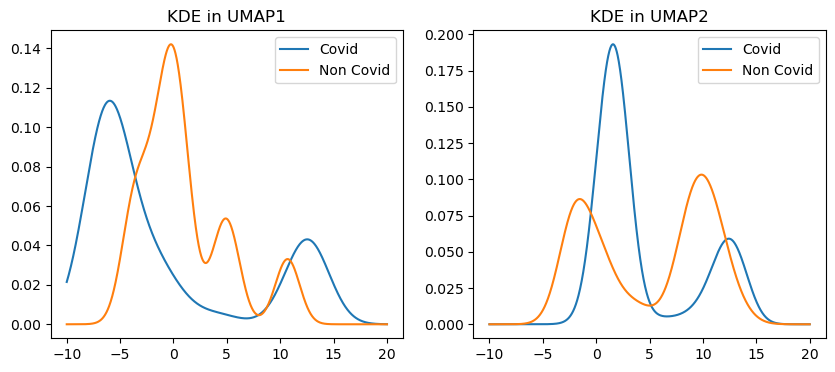

In [197]:
# Initialise the subplot function using number of rows and columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# For Covid KDE
ax1.plot(n_sample_covid, kde_x_covid_test, label='Covid')
ax1.plot(n_sample_covid, kde_x_n_covid_test, label='Non Covid')
ax1.legend()
ax1.set_title("KDE in UMAP1")

ax2.plot(n_sample_covid, kde_y_covid_test, label='Covid')
ax2.plot(n_sample_covid, kde_y_n_covid_test, label='Non Covid')
ax2.legend()
ax2.set_title("KDE in UMAP2")


### Plot test samples: covid_17 and ctrl_14 with the existing samples together.

Text(0.5, 1.0, 'KDE in UMAP2')

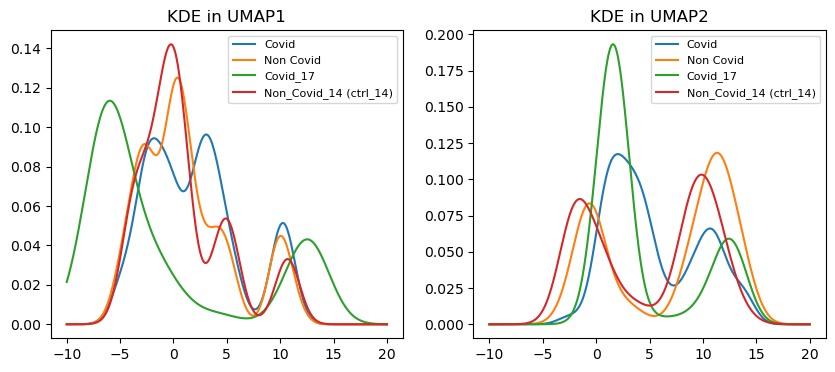

In [198]:
# Initialise the subplot function using number of rows and columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# For Covid KDE
ax1.plot(n_sample_covid, kde_x_covid, label='Covid')
ax1.plot(n_sample_covid, kde_x_n_covid, label='Non Covid')
ax1.plot(n_sample_covid, kde_x_covid_test, label='Covid_17')
ax1.plot(n_sample_covid, kde_x_n_covid_test, label='Non_Covid_14 (ctrl_14)')
ax1.legend(prop={'size': 8})
ax1.set_title("KDE in UMAP1")

ax2.plot(n_sample_covid, kde_y_covid, label='Covid')
ax2.plot(n_sample_covid, kde_y_n_covid, label='Non Covid')
ax2.plot(n_sample_covid, kde_y_covid_test, label='Covid_17')
ax2.plot(n_sample_covid, kde_y_n_covid_test, label='Non_Covid_14 (ctrl_14)')
ax2.legend(prop={'size': 8})
ax2.set_title("KDE in UMAP2")


<strike>#### A. Compare the existing sample distributions with the test sample distributions using T-test.

T-tests are generally used to compare means. In this case, we want to test whether the means of the income distribution are the same across the two groups. (ref: https://towardsdatascience.com/how-to-compare-two-or-more-distributions-9b06ee4d30bf) <br>
<br>
Null Hypothesis (H0): Independent sample means (existing covid patients: `kde_x_covid` and the test non-covid patients: `kde_x_n_covid_test`) are equal. (m1=m2)
Alternative Hypothesis (Ha): Independent sample means (`kde_x_covid` and `kde_x_n_covid_test`) are not equal. (m1!=m2)
</strike>

#### A. Compare the existing sample distributions with the test sample distributions based on KL-divergence.

In [256]:
import numpy as np  
from scipy.stats import norm  
from matplotlib import pyplot as plt

#compute KL Divergence
"""KL Divergence(P|Q)"""
def KL_div(p_probs, q_probs):    
    KL_div = p_probs * np.log(p_probs / q_probs)
    return np.sum(KL_div)

covid_14_pred = {'UMAP1': [], 'UMAP2': []} #[Comparison with the exsiting covid sample, Comarison with existing non-covid sample]
ctrl_17_pred = {'UMAP1': [], 'UMAP2': []} #[Comparison with the exsiting covid sample, Comarison with existing non-covid sample]

Existing sample: covid, Test sample: covid in UMAP1


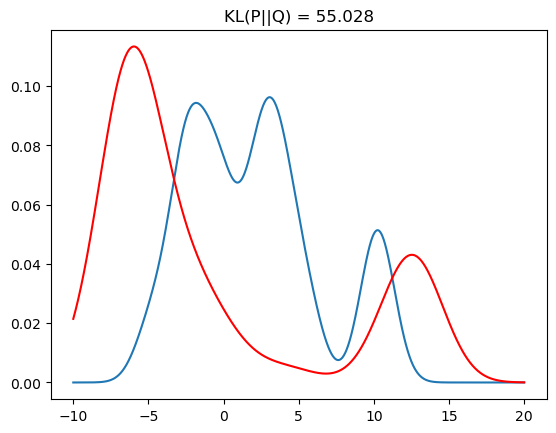

In [257]:
print(f"Existing sample: covid, Test sample: covid in UMAP1")
plt.title('KL(P||Q) = %1.3f' % KL_div(kde_x_covid, kde_x_covid_test))  
plt.plot(n_sample_covid, kde_x_covid)  
plt.plot(n_sample_covid, kde_x_covid_test, c='red')

covid_14_pred['UMAP1'].append(KL_div(kde_x_covid, kde_x_covid_test))

Existing sample: non-covid, Test sample: covid


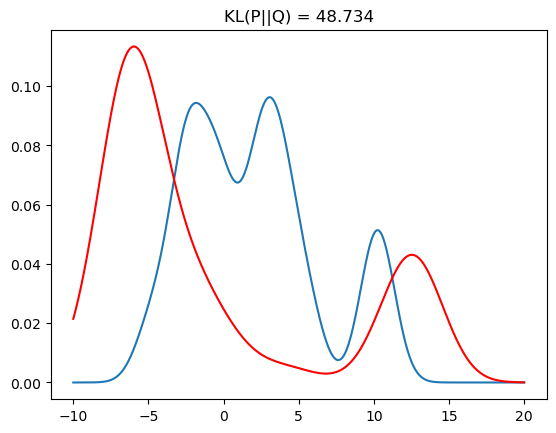

In [258]:
print(f"Existing sample: non-covid, Test sample: covid")
plt.title('KL(P||Q) = %1.3f' % KL_div(kde_x_n_covid, kde_x_covid_test))  
plt.plot(n_sample_covid, kde_x_covid)  
plt.plot(n_sample_covid, kde_x_covid_test, c='red')

covid_14_pred['UMAP1'].append(KL_div(kde_x_n_covid, kde_x_covid_test))

In [259]:
covid_14_pred

{'UMAP1': [55.02811056552109, 48.733604229608254], 'UMAP2': []}

Existing sample: covid, Test sample: non-covid


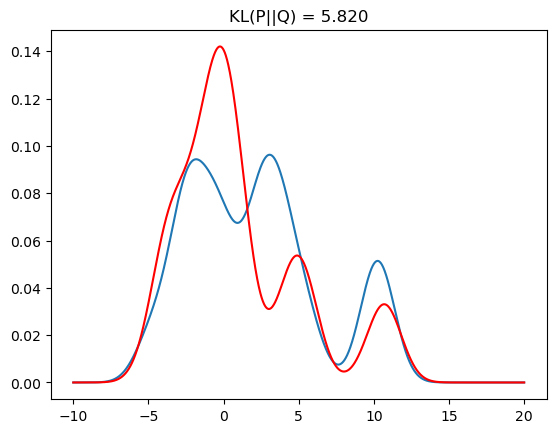

In [260]:
print(f"Existing sample: covid, Test sample: non-covid")
plt.title('KL(P||Q) = %1.3f' % KL_div(kde_x_covid, kde_x_n_covid_test))  
plt.plot(n_sample_covid, kde_x_covid)  
plt.plot(n_sample_covid, kde_x_n_covid_test, c='red')

ctrl_17_pred['UMAP1'].append(KL_div(kde_x_covid, kde_x_n_covid_test))

Existing sample: non-covid, Test sample: non-covid


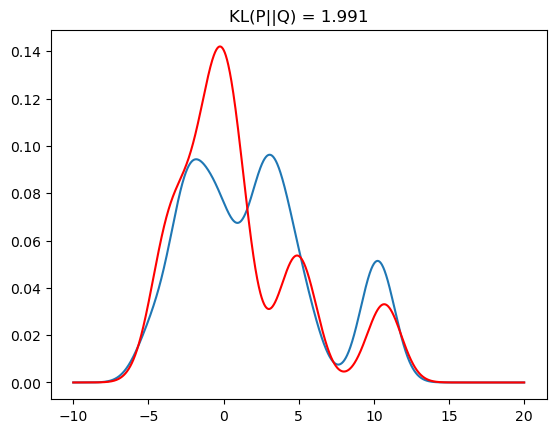

In [261]:
print(f"Existing sample: non-covid, Test sample: non-covid")
plt.title('KL(P||Q) = %1.3f' % KL_div(kde_x_n_covid, kde_x_n_covid_test))  
plt.plot(n_sample_covid, kde_x_covid)  
plt.plot(n_sample_covid, kde_x_n_covid_test, c='red')

ctrl_17_pred['UMAP1'].append(KL_div(kde_x_n_covid, kde_x_n_covid_test))

In [262]:
ctrl_17_pred

{'UMAP1': [5.819622734770412, 1.991120708033551], 'UMAP2': []}

##### UMAP 2

Existing sample: covid, Test sample: covid in UMAP2


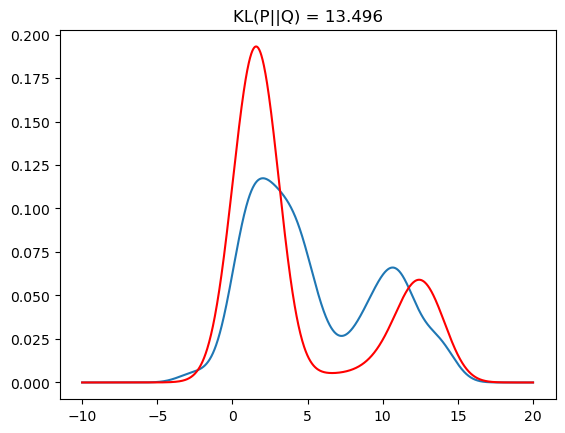

In [263]:
print(f"Existing sample: covid, Test sample: covid in UMAP2")
plt.title('KL(P||Q) = %1.3f' % KL_div(kde_y_covid, kde_y_covid_test))  
plt.plot(n_sample_covid, kde_y_covid)  
plt.plot(n_sample_covid, kde_y_covid_test, c='red')

covid_14_pred['UMAP2'].append(KL_div(kde_y_covid, kde_y_covid_test))


Existing sample: non-covid, Test sample: covid in UMAP2


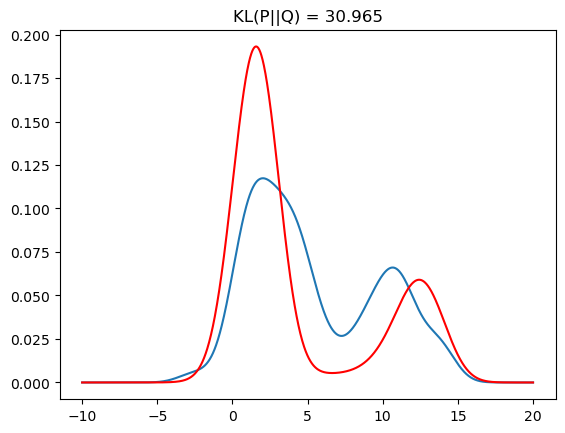

In [264]:
print(f"Existing sample: non-covid, Test sample: covid in UMAP2")
plt.title('KL(P||Q) = %1.3f' % KL_div(kde_y_n_covid, kde_y_covid_test))  
plt.plot(n_sample_covid, kde_y_covid)  
plt.plot(n_sample_covid, kde_y_covid_test, c='red')

covid_14_pred['UMAP2'].append(KL_div(kde_y_n_covid, kde_y_covid_test))

Existing sample: covid, Test sample: non-covid in UMAP2


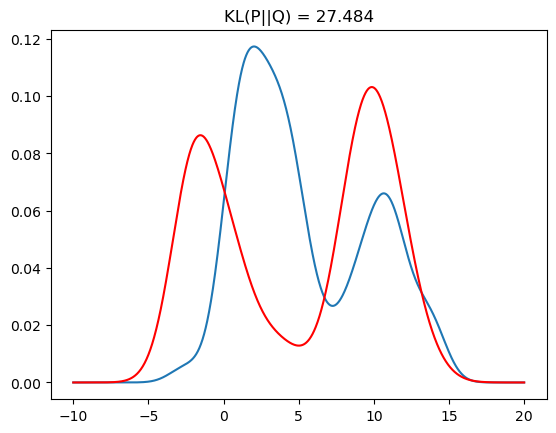

In [265]:
print(f"Existing sample: covid, Test sample: non-covid in UMAP2")
plt.title('KL(P||Q) = %1.3f' % KL_div(kde_y_covid, kde_y_n_covid_test))  
plt.plot(n_sample_covid, kde_y_covid)  
plt.plot(n_sample_covid, kde_y_n_covid_test, c='red')

ctrl_17_pred['UMAP2'].append(KL_div(kde_y_covid, kde_y_n_covid_test))

Existing sample: non-covid, Test sample: non-covid in UMAP2


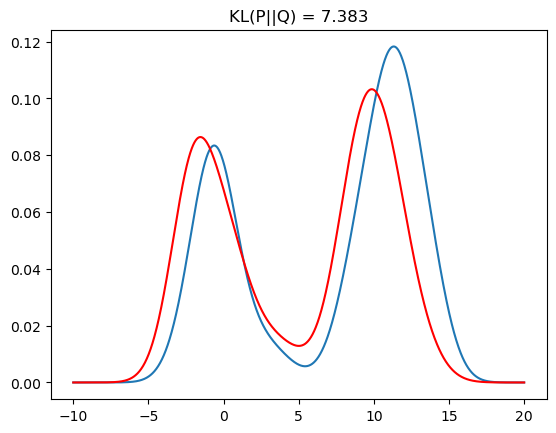

In [266]:
print(f"Existing sample: non-covid, Test sample: non-covid in UMAP2")
plt.title('KL(P||Q) = %1.3f' % KL_div(kde_y_n_covid, kde_y_n_covid_test))  
plt.plot(n_sample_covid, kde_y_n_covid)  
plt.plot(n_sample_covid, kde_y_n_covid_test, c='red')

ctrl_17_pred['UMAP2'].append(KL_div(kde_y_n_covid, kde_y_n_covid_test))

In [267]:
print("Result of covid_14_pred:", covid_14_pred)
print("Result of ctrl_17_pred:", ctrl_17_pred)

Result of covid_14_pred: {'UMAP1': [55.02811056552109, 48.733604229608254], 'UMAP2': [13.496154816143207, 30.964519668018326]}
Result of ctrl_17_pred: {'UMAP1': [5.819622734770412, 1.991120708033551], 'UMAP2': [27.48417097732824, 7.383220929865131]}


To produce a final prediction score, we sum up the KL-divergence score between UMAP1 and UMAP2, and then divide by 2 to get an average of UMAP1 and UMAP2.

Note--Mutual info: https://datascience.stackexchange.com/questions/9262/calculating-kl-divergence-in-python

In [273]:
avg_kld_covid_14 = []
avg_kld_ctrl_17 = []

# Calculate avg of kl-divergence in the covid test sample
for key in covid_14_pred.keys():
    if key=="UMAP1":
        kl_d_result = covid_14_pred[key]
    else:
        kl_d_result_2 = covid_14_pred[key]
        avg_0 = (kl_d_result[0]+kl_d_result_2[0])/2
        avg_kld_covid_14.append(avg_0)
        avg_1 = (kl_d_result[1]+kl_d_result_2[1])/2
        avg_kld_covid_14.append(avg_1)

print("avg_kld_covid_14:", avg_kld_covid_14)

# Calculate avg of kl-divergence in the non-covid test sample
for key in ctrl_17_pred.keys():
    if key=="UMAP1":
        kl_d_result = ctrl_17_pred[key]
    else:
        kl_d_result_2 = ctrl_17_pred[key]
        avg_0 = (kl_d_result[0]+kl_d_result_2[0])/2
        avg_kld_ctrl_17.append(avg_0)
        avg_1 = (kl_d_result[1]+kl_d_result_2[1])/2
        avg_kld_ctrl_17.append(avg_1)

print("avg_kld_ctrl_17:", avg_kld_ctrl_17)

avg_kld_covid_14 = np.array(avg_kld_covid_14)
avg_kld_ctrl_17 = np.array(avg_kld_ctrl_17)

avg_kld_covid_14: [34.262132690832146, 39.84906194881329]
avg_kld_ctrl_17: [16.651896856049326, 4.687170818949341]


Pick up the index which has the minimum value from avg_kld_covid_14 and avg_kld_covid_14. <br>

-> If the KL divergence between two distributions is zero, then it indicates that the distributions are identical. Thus, the smaller value is better.

In [275]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
# covid_14_true_index = 0
# ctrl_17_true_index = 1

y_true = [0,1]
y_pred = [np.argmin(avg_kld_covid_14), np.argmin(avg_kld_ctrl_17)]

print("Accuracy =", accuracy_score(y_true, y_pred))
print("Precision = ", precision_score(y_true, y_pred, average='macro'))
print("Recall = ", recall_score(y_true, y_pred, average='macro'))
print("f1 score = ", f1_score(y_true, y_pred, average='macro'))

Accuracy = 1.0
Precision =  1.0
Recall =  1.0
f1 score =  1.0
